In [1]:
%matplotlib inline
import sys 
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Subject Parameters
SBJs = ['P1','P2','P3','P4','P5','P6','P7','P8','P9'] # 'IR57', 'Rana_1.6', 'Adi_1.7'

results_dir = '/Users/colinhoy/Code/PRJ_Error/results/'
fig_type = '.png'
log_dir = '/Users/colinhoy/Code/PRJ_Error/logs/'
path = '/Users/colinhoy/Code/PRJ_Error/data/logs/'
# paths = {'Rana': '/Users/colinhoy/Code/PRJ_Error/data/logs/',
#          'Adi': '/Users/colinhoy/Code/PRJ_Error/data/logs/',
#          'IR57': '/Users/colinhoy/Code/PRJ_Error/data/logs/'}
logs = {'Rana_1.6': 'Rana2_response_log_20170321103129_DATA.txt',
        'Adi_1.7': 'adi_response_log_20170321153641.txt',
        'IR57': '857_response_log_20170322112243.txt',
        'P1': 'Pilot1_2_response_log_20170412131644.txt',
        'P2': 'pilot2_response_log_20170412140615.txt',
        'P3': 'pilot3_response_log_20170413110228.txt',
        'P4': 'Pilot4_2_response_log_20170418140941.txt',
        'P5': 'colin_real_response_log_20170412103113.txt',
        'P6': 'pilot_adi_response_log_20170414122257.txt',
        'P7': 'pilot_Rana_response_log_20170415155844.txt',
        'P8': 'Giao_response_log_20170419161340.txt',
        'P9': 'Sundberg_response_log_20170419150222.txt'
       }
SBJ = 'P1'

In [9]:
df = pd.DataFrame()
for SBJ in SBJs:
    # Load Data
    print('======================= Loading {0} ======================='.format(SBJ))
    log_filename = path+logs[SBJ]

    log_file = open(log_filename,'r')
    log = log_file.readlines()
    log_file.close()

    resp_lines = [line for line in log if line.find('Outcome=')!=-1]

    # Process script specific variables
    for line in log:
        # ITIs and boundaries between them
        if line.find('ITIs')!=-1:
            ITIs = [float(string) \
                        for string in line[line.find('[')+1:line.find(']')].split(',')]
            ITI_bounds = np.mean([ITIs[:-1],ITIs[1:]],0)
        # Tolerance limits/clamps
        if line.find('tolerance_lim')!=-1:
            tolerance_lim = [float(string) \
                             for string in line[line.find('[')+1:line.find(']')].split(',')]
        # Trials per block
        if line.find('n_trials')!=-1:
            trials_per_block = int(line[line.find('=')+2:])
    #     if line.find('script_version')!=-1:
    #         verion = line...

    # ITI_bounds = [np.mean(a,b) for a, b in zip(ITIs[:-1],ITIs[1:])]
    print('trials_per_block: ',trials_per_block)
    print('ITIs:',ITIs, ITI_bounds)
    print('tolerance_lim:',tolerance_lim)

    data = pd.DataFrame({'Block': [line[line.find('B')+1] for line in resp_lines],
                         'Trial': [int(line[line.find('_T')+2:line.find(':')]) for line in resp_lines],
                         'Condition': [line[line.find('_type')+8:line.find('_type')+12] for line in resp_lines],
                         'Hit': [line.count('WIN') for line in resp_lines],
                         'RT': [line[line.find('RT')+5:line.find('RT')+5+13].strip() for line in resp_lines],
                         'Tolerance': [float(line[line.find('tol')+12:line.find('\n')]) for line in resp_lines],
                         'Reversal': np.zeros(len(resp_lines)),
                         'Timestamp': [float(line[:line.find('.')+4]) for line in resp_lines]})
    data['Score'] = [100 if data['Hit'][ix]==1 else -100 for ix in range(len(data))]
    data['Score Total'] = [data['Score'][ix]+np.sum(data['Score'][:ix]) for ix in range(len(data))]
    data['Hit Total'] = [data['Hit'][ix]+np.sum(data['Hit'][:ix]) for ix in range(len(data))]
    data['ITI'] = [data['Timestamp'][ix]-data['Timestamp'][ix-1]-2.8 if ix!=0 else 0 \
                   for ix in range(len(data))]
    data.loc[data['Trial']==0,'ITI'] = 0
    data.loc[data['Block']==-1,'ITI'] = 0
#     if len(ITIs)==3:
#         data['ITI type'] = ['short' if data['ITI'][ix]<ITI_bounds[0] else 'long' if data['ITI'][ix]>ITI_bounds[1] else 'medium'\
#                             for ix in range(len(data))]
#         ITI_plot_order = ['short','medium','long']
#     else:
    data['ITI type'] = ['short' if data['ITI'][ix]<0.5 else 'long' for ix in range(len(data))]
    ITI_plot_order = ['short','long']

    # Label post-correct (PC), post-error (PE) trials
    data['PE'] = [False for _ in range(len(data))]
    for ix in range(len(data)):
        # Exclude training data and first trial of the block
        if (data.loc[ix,'Block']!=-1) and (data.loc[ix,'Trial']!=0):
            if data.loc[ix-1,'Hit']==0:
                data.loc[ix,'PE'] = True

    # Fix Reversals, Block, and missed RTs
    for ix in range(len(data)):
        if (ix>0) and (data['Hit'][ix]!=data['Hit'][ix-1]):
            data.loc[ix,'Reversal'] = 1
        if data['RT'][ix][0:2]=='-1':
            data.loc[ix,'RT'] = -1;
        else:
            if data['RT'][ix].find(';')!=-1:
                data.loc[ix,'RT'] = float(data['RT'][ix][:data['RT'][ix].find(';')])
            else:
                data.loc[ix,'RT'] = float(data['RT'][ix])
        if data['Block'][ix]=='T':
            data.loc[ix,'Block'] = -1
        else:
            data.loc[ix,'Block'] = int(data['Block'][ix])

    # Accuracy
    accuracy = data['Hit'].groupby([data['Block'],data['Condition']]).mean()
    for ix in range(len(data)):
        data.loc[ix,'Accuracy'] = accuracy[data.loc[ix,'Block'],data.loc[ix,'Condition']]
        
    data['SBJ'] = [SBJ for _ in range(len(data))]
    frames = [df,data]
    df = pd.concat(frames,ignore_index=True)
    %reset_selective -f data

======================= Loading P1 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] [ 0.475  0.825]
tolerance_lim: [0.2, 0.015]
======================= Loading P2 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] [ 0.475  0.825]
tolerance_lim: [0.2, 0.015]
======================= Loading P3 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] [ 0.475  0.825]
tolerance_lim: [0.2, 0.015]
======================= Loading P4 =======================
trials_per_block:  75
ITIs: [0.2, 0.4, 0.7, 1.0] [ 0.3   0.55  0.85]
tolerance_lim: [0.2, 0.015]
======================= Loading P5 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] [ 0.475  0.825]
tolerance_lim: [0.2, 0.015]
======================= Loading P6 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] [ 0.475  0.825]
tolerance_lim: [0.2, 0.015]
======================= Loading P7 =======================
trials_per_block:  75
ITIs: [0.3, 0.65, 1.0] 

In [42]:
# all_RTs = np.array([sbj_df[SBJ]['RT'].values for SBJ in SBJs]).flatten()

In [4]:
# Block Divisions
block_start_ix = data[data['Trial']==0].index
block_mid_ix = [ix+trials_per_block/2 for ix in block_start_ix[1:]]
# Add in training: 0-19=10; 20-34:27.5 
#!!!assumes 5 examples, 15 of each training, lumps together examples and easy train
block_mid_ix.insert(0,27.5)   #examples
block_mid_ix.insert(0,10)   #easy training (would be 12.5 if splitting examples/train)
# block_mid_ix.insert(0,2.5)    #hard training

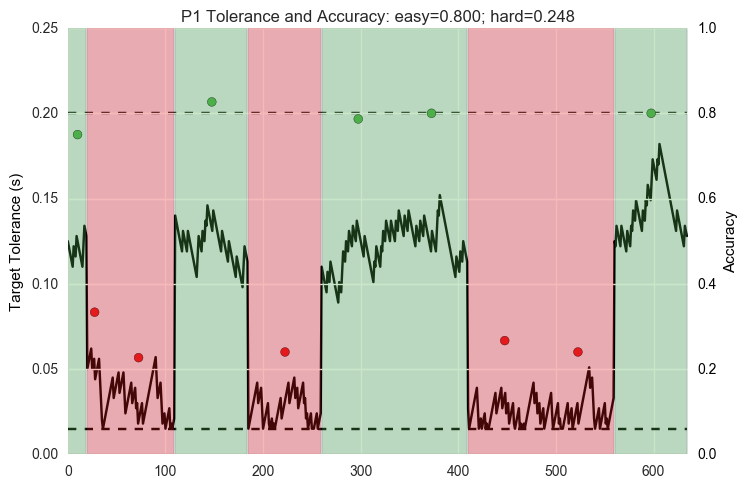

In [11]:
# f, ax1 = plt.subplots()
# x = range(len(data))
# plot_title = '{0} Tolerance and Accuracy: easy={1:0.3f}; hard={2:0.3f}'.format(
#                 SBJ, data[data['Condition']=='easy']['Hit'].mean(),
#                 data[data['Condition']=='hard']['Hit'].mean())
    
# colors = {'easy': [c/255 for c in [77,175,74]],
#           'hard': [c/255 for c in [228,26,28]],
#           'accuracy': 'k'}#[c/255 for c in [55,126,184]]}
# accuracy_colors = [colors[accuracy.index[ix][1]] for ix in range(len(accuracy))]
# #scale = {'Hit Total': np.max(data['Tolerance'])/np.max(data['Hit Total']),
# #         'Score Total': np.max(data['Tolerance'])/np.max(data['Score Total'])}

# ax1.plot(data['Tolerance'],'k',label='Tolerance')
# ax1.plot(x,[tolerance_lim[0] for _ in x],'k--')
# ax1.plot(x,[tolerance_lim[1] for _ in x],'k--')
# ax1.set_ylabel('Target Tolerance (s)', color='k')
# ax1.set_xlim([0,len(data)])
# ax1.set_ylim([0, 0.25])

# ax2 = ax1.twinx()
# # ax2.plot(data['Hit Total']/np.max(data['Hit Total']),'k',label='Hit Total')
# ax2.scatter(block_mid_ix, accuracy, s=40, c=accuracy_colors,
#            edgecolors=colors['accuracy'])#,linewidths=2)
# ax2.fill_between(x, 1, 0, where=data['Condition']=='easy',
#                 facecolor=colors['easy'], alpha=0.3, label='hard')
# ax2.fill_between(x, 1, 0, where=data['Condition']=='hard',
#                 facecolor=colors['hard'], alpha=0.3, label='easy')
# ax2.set_ylabel('Accuracy', color=colors['accuracy'])
# ax2.tick_params('y', colors=colors['accuracy'])
# ax2.set_xlabel('Trials')
# ax2.set_xlim([0,len(data)])
# ax2.set_ylim([0, 1])

# plt.title(plot_title)

# plt.savefig(results_dir+'tolerance_plots/'+SBJ+'_tolerance_plot'+fig_type)

//anaconda/envs/neuro_stats/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


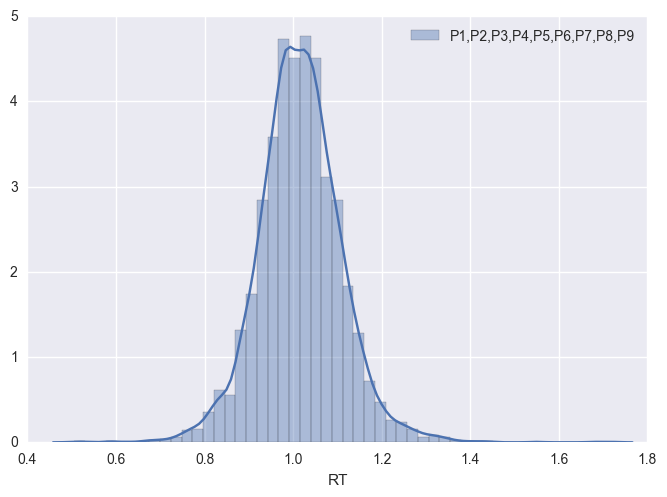

In [5]:
# SBJ = 'P7'
all_SBJ_lab = ','.join(SBJs)
ax = sns.distplot(df['RT'],label=all_SBJ_lab,kde=True,norm_hist=False)
# ax2 = sns.distplot(df[df['SBJ']==SBJ]['RT'],label=SBJ,norm_hist=False)
# plt.subplots_adjust(top=0.9)
ax.legend() # can also get the figure from plt.gcf()
plt.savefig(results_dir+'RT_plots/GRP_RT_hist'+fig_type)

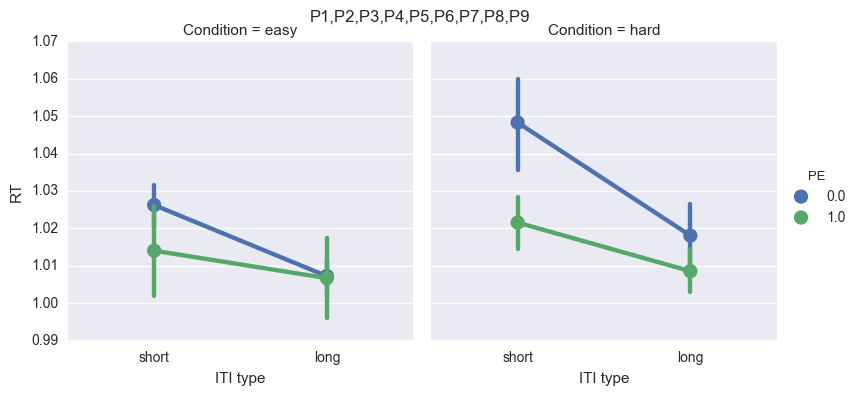

In [10]:
plot = sns.factorplot(data=df,x='ITI type',y='RT',hue='PE',col='Condition',kind='point',
               ci=95,order=ITI_plot_order);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(all_SBJ_lab) # can also get the figure from plt.gcf()

plt.savefig(results_dir+'RT_plots/GRP_RT_PE_ITI_hit'+fig_type)

In [11]:
# Break kdown by post-long and post-short trials
df['postlong'] = [False if ix==0 else True if df.loc[ix-1,'RT']>1 else False for ix in range(len(df))]
df_PL = df[df['postlong']==True]
df_PS = df[df['postlong']==False]

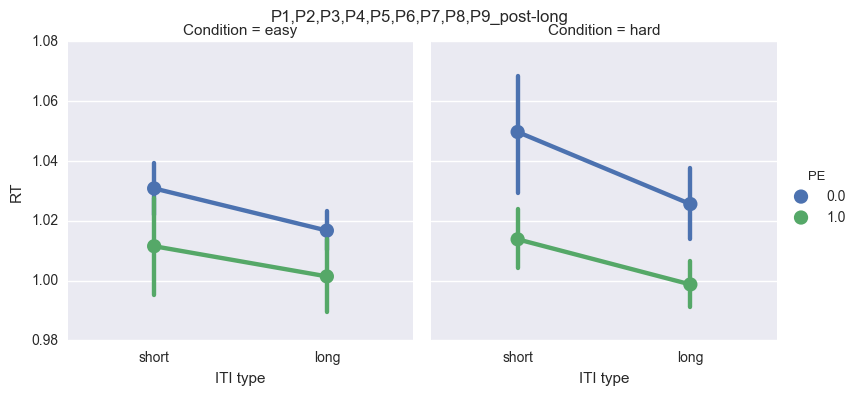

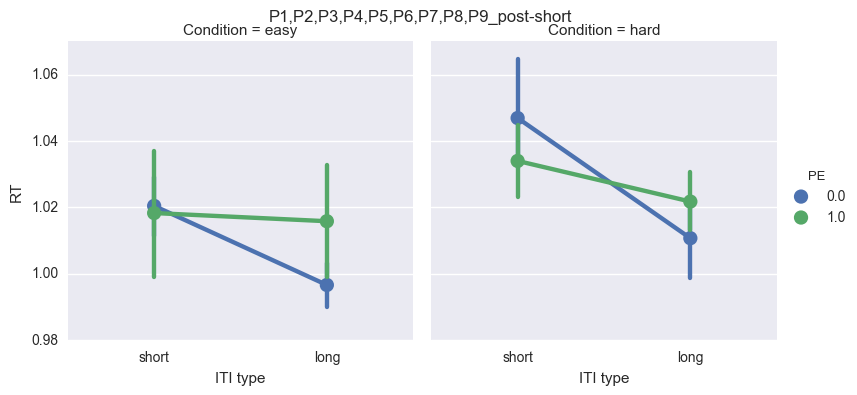

In [13]:
plot = sns.factorplot(data=df_PL,x='ITI type',y='RT',hue='PE',col='Condition',kind='point',
               ci=95,order=ITI_plot_order);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(all_SBJ_lab+'_post-long') # can also get the figure from plt.gcf()

plt.savefig(results_dir+'RT_plots/GRP_RT_PE_ITI_hit'+fig_type)
plot2 = sns.factorplot(data=df_PS,x='ITI type',y='RT',hue='PE',col='Condition',kind='point',
               ci=95,order=ITI_plot_order);
plt.subplots_adjust(top=0.9)
plot2.fig.suptitle(all_SBJ_lab+'_post-short') # can also get the figure from plt.gcf()

plt.savefig(results_dir+'RT_plots/GR_EEG_configP_RT_PE_ITI_hit'+fig_type)

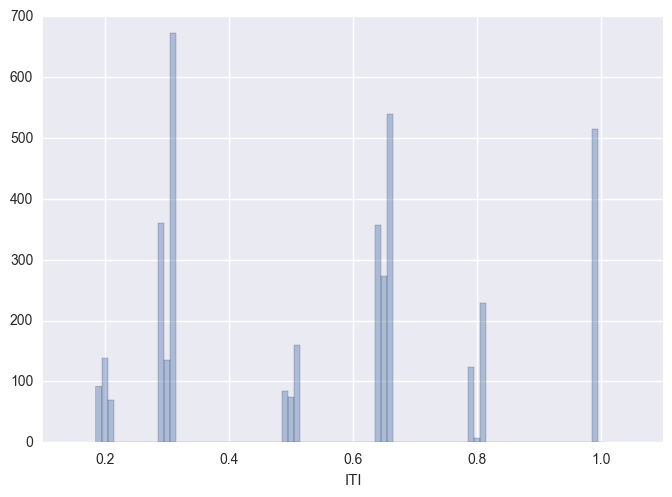

In [16]:
# ITI Histograms
sns.distplot(df['ITI'],bins=np.arange(0.185,1.01,0.01),kde=False)

# OLD SHIT

In [ ]:
RT_means = {'short': np.empty(2),
           'medium': np.empty(2),
           'long': np.empty(2)}
RT_cnt = {'short': np.empty(2),
           'medium': np.empty(2),
           'long': np.empty(2)}
for ITI_type in ['short','medium','long']:
    RT_means[ITI_type][0] = data.loc[(data['PE']==False) & (data['ITI type']==ITI_type),'RT'].mean()
    RT_cnt[ITI_type][0] = sum([(data['PE']==False) & (data['ITI type']==ITI_type)]).sum()
    RT_means[ITI_type][1] = data.loc[(data['PE']==True) & (data['ITI type']==ITI_type),'RT'].mean()
    RT_cnt[ITI_type][1] = sum([(data['PE']==True) & (data['ITI type']==ITI_type)]).sum()
    
# print(ITI_type)
# print('PE: ',data.loc[data['PE']==True,'RT'].mean(),sum(data['PE']==True))
# print('PC: ',data.loc[data['PE']==False,'RT'].mean(),sum(data['PE']==False))

In [ ]:
def makeECDF(sample):
    def ECDF(x):
        N = len(sample)
        cumsum = sample<=x
        CDF = np.sum(cumsum)/N
        return CDF
    return ECDF

ecdf = makeECDF(sample)
xs = np.linspace(0,1,len(sample))
ys = [ecdf(x) for x in xs]
plt.plot(xs,ys)
sns.distplot(sample,rug=True,hist=False,kde=False)

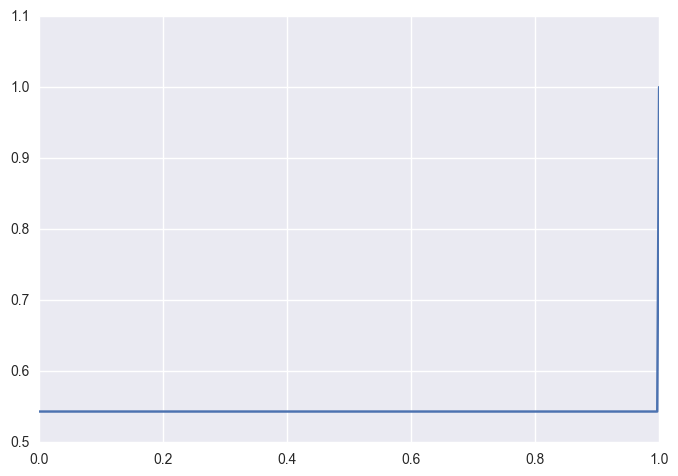

In [43]:
def makeECDF(sample):
    def ECDF(x):
        N = len(sample)
        cumsum = sample<=x
        CDF = np.sum(cumsum)/N
        return CDF
    return ECDF

ecdf = makeECDF(data['Correct'])
xs = np.linspace(0,1,len(data))
ys = [ecdf(x) for x in xs]
plt.plot(xs,ys)


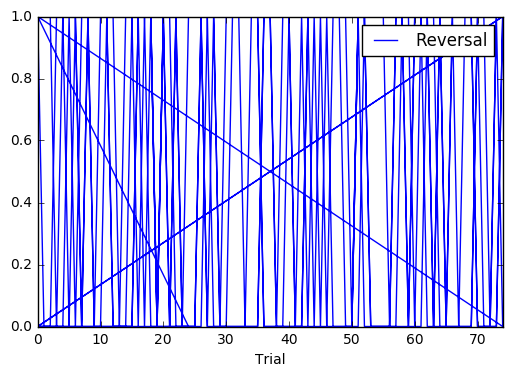

In [9]:
data.plot(x='Trial',y='Reversal')

In [22]:
n_blocks = 2
np.random.permutation([b for b in [0, 1] for _ in range(n_blocks)])

array([0, 1, 0, 1])